# Librerías 

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [54]:
import numpy as np

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# Visualización de datos

In [7]:
ds = tfds.load('fashion_mnist', split='train')
dataiterator = ds.as_numpy_iterator()

In [8]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

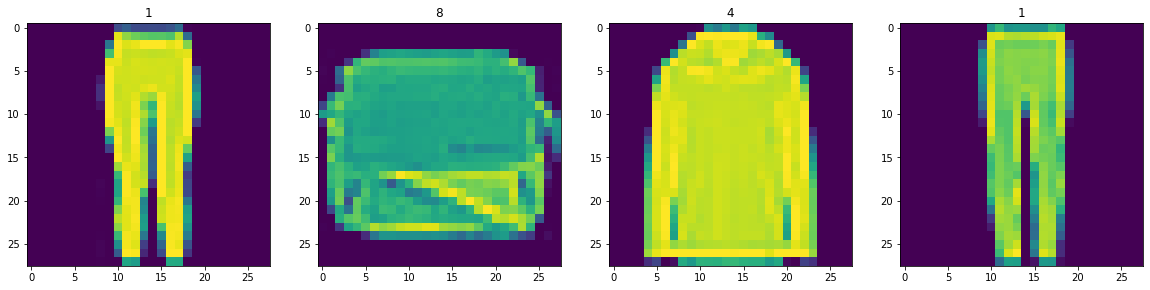

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])    

In [14]:
def scale_images(data):
    image = data['image']
    return image/255

In [15]:
#ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

# Neural Network

In [18]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [19]:
generator = build_generator()

In [20]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [37]:
img = generator.predict(np.random.randn(4,128,1))

In [38]:
img.shape

(4, 28, 28, 1)

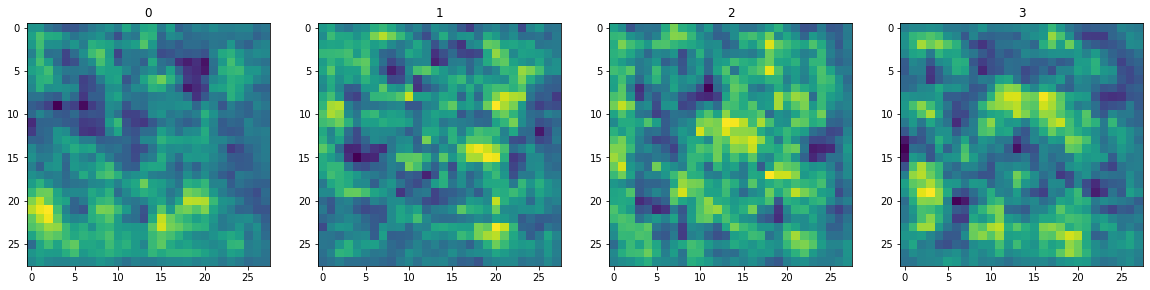

In [22]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)    

In [30]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [31]:
discriminator = build_discriminator()

In [32]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)      

In [61]:
img = generator.predict(np.random.randn(4,128,1))

In [60]:
discriminator.predict(img)

array([[0.49671087],
       [0.49673885],
       [0.4965797 ],
       [0.49689427]], dtype=float32)

# Entrenamiento

In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [65]:
g_opt =  Adam(learning_rate=0.0001)
d_opt =  Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [66]:
from tensorflow.keras.models import Model

In [70]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.35725296e+00],
        [ 1.30061865e+00],
        [ 2.59316087e-01],
        [-2.47301206e-01],
        [-1.00776315e+00],
        [ 5.43192804e-01],
        [ 8.50532711e-01],
        [-4.70570534e-01],
        [ 1.63948083e+00],
        [ 2.60007858e-01],
        [ 9.83789384e-01],
        [ 2.01363608e-01],
        [-1.70521963e+00],
        [-3.09964210e-01],
        [ 1.04089189e+00],
        [-4.91986632e-01],
        [-9.11307991e-01],
        [-1.10521615e+00],
        [ 1.49368748e-01],
        [-1.55363631e+00],
        [-7.70038843e-01],
        [-6.28894269e-01],
        [ 2.74335206e-01],
        [-1.05363488e+00],
        [ 1.35334456e+00],
        [ 2.15019912e-01],
        [ 1.24388075e+00],
        [-7.07701385e-01],
        [ 1.62417993e-01],
        [-7.01242149e-01],
        [-1.01849154e-01],
        [ 1.00274408e+00],
        [-7.77931035e-01],
        [ 6.58878461e-02],
        [ 4.12693322e-01],
  

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake = tf.concat([noise_real,noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
    
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variable)
        self.d_opt.apply_gradients(zip(dgrad, self.disccriminator.trainable_variables))             
            
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1), training = True)) 
            predicted_labels = self.discriminator(gen_images, training=False)
            
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss,"g_loss":total_g_loss}                        

In [ ]:
@tf.function
def tra